# Neural network scikit-learn version for ML CUP

## Imports

In [227]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Utils

In [228]:
def plot_training_history(history):
    """
    Plot training and validation loss and mean euclidean error (MEE) from a model's history.

    Parameters:
    ----------
    - history: Dictionary containing the training history with keys 'loss', 'val_loss', 'mee', and 'val_mee'.
    """

    # Extract data from the history dictionary
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_mee = history['mee']
    val_mee = history['val_mee']
    
    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st subplot)
    plt.plot(epochs, train_loss, 'b-o', label='Training MSE')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation MSE')  # Plot validation loss if available
    plt.title('Training and Validation MSE')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('MSE')  # Set the y-axis label
    plt.legend()  # Show the legend
    plt.grid(True)  # Show the grid

    # Plot the training and validation mean euclidean error (MEE)
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd subplot)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')  # Plot training MEE
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')  # Plot validation MEE if available
    plt.title('Training and Validation MEE')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('MEE')  # Set the y-axis label
    plt.legend()  # Show the legend
    plt.grid(True)  # Show the grid

    # Adjust the layout to prevent overlap
    plt.tight_layout()
    # Display the plots
    plt.show()

In [229]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    Parameters:
    ---------- 
    - param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).
                         
    Returns:
    ----------
    - list: List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination into a dictionary with hyperparameter names as keys
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

In [230]:
def create_hidden_layers(hidden_size, num_layers):
    """
    Create a tuple to configure hidden_layer_sizes based on the number of layers and the size of each layer.
    
    Parameters
    ----------
    - hidden_size (int): Number of units for each hidden layer.
    - num_layers (int): Number of hidden layers.
    
    Returns:
    ----------
    - tuple: Configuration for hidden_layer_sizes.
    """
    # Check if the number of layers is at least 1
    if num_layers <= 0:
        raise ValueError("The number of hidden layers must be at least 1.")
    
    # Check if the size of each hidden layer is greater than 0
    if hidden_size <= 0:
        raise ValueError("The size of hidden layers must be greater than 0.")
    
    # Create a tuple with the specified number of layers, each having the specified size
    return tuple([hidden_size] * num_layers)

In [231]:
def mean_euclidean_error(y_true, y_pred):
        """
        Calculate the Mean Euclidean Error between the true and predicted values.

        The Euclidean error is computed as the Euclidean distance (L2 norm) between 
        each pair of true and predicted values. The mean of these distances is then 
        returned as the final error metric.

        Parameters
        ----------
        y_true : array-like of shape (n_samples, n_features)
                True values or ground truth. Each row corresponds to a sample and each 
                column corresponds to a feature.
        
        y_pred : array-like of shape (n_samples, n_features)
                Predicted values. Each row corresponds to a sample and each column 
                corresponds to a feature.

        Returns
        -------
        float
                The mean Euclidean error between the true and predicted values.

        Examples
        --------
        >>> import numpy as np
        >>> y_true = np.array([[1, 2], [3, 4], [5, 6]])
        >>> y_pred = np.array([[1, 2], [2, 3], [4, 5]])
        >>> mean_euclidean_error(y_true, y_pred)
        1.0
        """
        return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

## Data load

In [232]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'  # Path to the training dataset
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'   # Path to the test dataset
data_train = pd.read_csv(train_path, skiprows=7)  # Load the training data, skipping the first 7 rows
data_test = pd.read_csv(test_path, skiprows=7)    # Load the test data, skipping the first 7 rows

# Drop the ID column and split inputs/outputs for training data
X_train = data_train.iloc[:, 1:-3].values  # Extract input features (all columns except the first and last three)
y_train = data_train.iloc[:, -3:].values   # Extract target values (last three columns: TARGET_x, TARGET_y, TARGET_z)

# Drop the ID column and split inputs/outputs for test data
X_test = data_test.iloc[:, 1:].values  # Extract input features (all columns except the first)

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()  # Initialize the StandardScaler for input features
X_train_scaled = input_scaler.fit_transform(X_train)  # Fit the scaler on training data and transform it
X_test_scaled = input_scaler.transform(X_test)        # Transform the test data using the same scaler

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()  # Initialize the MinMaxScaler for output values
y_train_scaled = output_scaler.fit_transform(y_train)  # Fit the scaler on training target values and transform them


## Model creation

In [233]:
def create_nn(activ_type = 'tanh', optim_type = 'sgd', reg_flag = False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, batch_size = 4, epochs = 50):
    """
                Create a neural network model using MLPRegressor from scikit-learn.

                Parameters:
                ---------
                - activ_type (str): Activation function for the hidden layer. Default is 'tanh'.
                                  Options include 'identity', 'logistic', 'tanh', 'relu'.
                - optim_type (str): The solver for weight optimization. Default is 'sgd'.
                                  Options include 'lbfgs', 'sgd', 'adam'.
                - reg_flag (bool): If True, apply L2 regularization. Default is False.
                - learning_rate (float): Initial learning rate. Default is 0.01.
                - hidden_size (int): Number of neurons in each hidden layer. Default is 6.
                - hidden_layers (int): Number of hidden layers. Default is 1.
                - regularization (float): L2 penalty (regularization term) parameter. Default is 0.01.
                - momentum (float): Momentum for gradient descent update. Default is 0.9.
                - batch_size (int): Size of minibatches for stochastic optimizers. Default is 4.
                - epochs (int): Maximum number of iterations. Default is 50.

                Returns:
                --------
                model (MLPRegressor): Configured MLPRegressor model.
                """
    
    
    # Create a tuple for hidden layer sizes based on the number of layers and size of each layer
    tuple_hidden_layers = create_hidden_layers(hidden_size, hidden_layers)

    if reg_flag:
        # If regularization is enabled, create the MLPRegressor with L2 penalty (regularization term)
        model = MLPRegressor(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=regularization, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size=batch_size, random_state=42)
    else:
        # If regularization is not enabled, create the MLPRegressor without L2 penalty
        model = MLPRegressor(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=0, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size=batch_size, random_state=42)

    # Return the configured MLPRegressor model
    return model

In [234]:
def fit(model: MLPRegressor, X_train, y_train, X_test, y_test, epochs=100, batch_size=1, patience=5):
    """
    Train the MLPRegressor model with early stopping and record the training history.

    Parameters:
    ----------
    - model: MLPRegressor
        The neural network model to be trained.
    - X_train: array-like
        Training input samples.
    - y_train: array-like
        Training target values.
    - X_test: array-like
        Validation input samples.
    - y_test: array-like
        Validation target values.
    - epochs: int, optional (default=100)
        Number of epochs to train the model.
    - batch_size: int, optional (default=1)
        Size of minibatches for stochastic optimizers.
    - patience: int, optional (default=5)
        Number of epochs with no improvement after which training will be stopped.

    Returns:
    -------
    - best_model: MLPRegressor
        The best model based on validation loss.
    - history: dict
        Dictionary containing the training history with keys 'loss', 'val_loss', 'mee', and 'val_mee'.
    """

    # Initialize the history dictionary to store training and validation metrics
    history = {
        "loss": [],
        "val_loss": [],
        "mee": [],
        "val_mee": []
    }

    # Initialize variables for early stopping
    best_val_loss = np.inf  # Best validation loss starts as infinity
    best_model = None  # Placeholder for the best model
    epochs_without_improvement = 0  # Counter for epochs without improvement

    # Manual training loop for the specified number of epochs
    for epoch in range(epochs):
        # Shuffle the training data at the beginning of each epoch
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        # Partially fit the model on the shuffled training data
        model.partial_fit(X_train_shuffled, y_train_shuffled)

        # Predict on training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        # Calculate training and validation loss (MSE)
        train_loss = mean_squared_error(y_train, train_pred)
        val_loss = mean_squared_error(y_test, test_pred)

        # Calculate training and validation mean euclidean error (MEE)
        train_mee = mean_euclidean_error(y_train, train_pred)
        val_mee = mean_euclidean_error(y_test, test_pred)

        # Append the metrics to the history dictionary
        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["mee"].append(train_mee)
        history["val_mee"].append(val_mee)

        # Check for improvement in validation loss for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update the best validation loss
            best_model = model  # Save the current model as the best model
            epochs_without_improvement = 0  # Reset the counter
        else:
            epochs_without_improvement += 1  # Increment the counter

        # Stop training if no improvement for `patience` consecutive epochs
        if epochs_without_improvement >= patience:
            break

    # Return the best model and the training history
    return best_model, history

## K-fold cross validation

In [235]:
def k_fold_cross_validation(data, labels, activ_type='tanh', optim_type='sgd', reg_flag=False, params=None):
    """
    Perform k-fold cross-validation on the given dataset using the specified neural network configuration.

    Parameters:
    ----------
    - data: array-like
        Input features.
    - labels: array-like
        Target values.
    - activ_type: str, optional (default='tanh')
        Activation function for the hidden layers.
    - optim_type: str, optional (default='sgd')
        Optimizer type for training the neural network.
    - reg_flag: bool, optional (default=False)
        Flag to indicate whether to use regularization.
    - params: dict, optional
        Dictionary containing hyperparameters for the neural network.

    Returns:
    -------
    - avg_score: float
        Average mean euclidean error (MEE) across all folds.
    - history: dict
        Training history of the final model.
    - model: MLPRegressor
        The final trained model.
    """
    # Configure k-fold cross-validation with 5 splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize variables to store fold number and MEE for each fold
    fold_no = 1
    mee_per_fold = []

    # Loop through each fold
    for train_index, val_index in kfold.split(data):
        # Split the dataset into training and validation sets for the current fold
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Create the neural network model with the specified parameters
        model = create_nn(activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'],
                          batch_size=params["batch_size"],
                          epochs=params["epochs"])

        # Train the model with early stopping
        model, history = fit(model, X_train, y_train,
                             X_val, y_val,
                             epochs=params['epochs'],
                             batch_size=params['batch_size'],
                             patience=params['patience'])

        # Get the best validation MEE score for the current fold
        score = min(history['val_mee'])
        mee_per_fold.append(score)  # Append the score to the list
        fold_no += 1  # Increment the fold number

    # Calculate the average MEE score across all folds
    avg_score = np.mean(mee_per_fold)

    # Split the dataset into training and validation sets for the final model
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Create the neural network model with the specified parameters
    model = create_nn(activ_type=activ_type,
                      optim_type=optim_type,
                      reg_flag=reg_flag,
                      learning_rate=params['learning_rate'], 
                      hidden_size=params['hidden_size'], 
                      hidden_layers=params['hidden_layers'], 
                      regularization=params['regularization'], 
                      momentum=params['momentum'],
                      batch_size=params["batch_size"],
                      epochs=params["epochs"])

    # Train the model with early stopping
    model, history = fit(model, X_train, y_train,
                         X_val, y_val,
                         epochs=params['epochs'],
                         batch_size=params['batch_size'],
                         patience=params['patience'])

    # Return the average MEE score, training history, and the final model
    return avg_score, history, model

## Greedy search

In [236]:
def greed_search(data, labels, activ_type='tanh', optim_type='sgd', reg_flag=False, param_grid=None):
    """
    Perform a greedy search to find the best hyperparameters for the neural network.

    Parameters:
    ----------
    - data: array-like
        Input features.
    - labels: array-like
        Target values.
    - activ_type: str, optional (default='tanh')
        Activation function for the hidden layers.
    - optim_type: str, optional (default='sgd')
        Optimizer type for training the neural network.
    - reg_flag: bool, optional (default=False)
        Flag to indicate whether to use regularization.
    - param_grid: list of dict, optional
        List of dictionaries containing hyperparameters to test.

    Returns:
    -------
    - best_scores: list
        List of the best scores (mean euclidean error) for the top 10 hyperparameter configurations.
    - best_params_list: list
        List of the best hyperparameter configurations.
    - best_models: list
        List of the best models.
    - best_histories: list
        List of the training histories for the best models.
    """

    # Initialize lists to store the best scores, parameters, models, and training histories
    best_scores = []
    best_params_list = []
    best_models = []
    best_histories = []

    # Iterate over each set of hyperparameters in the parameter grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")

        # Perform k-fold cross-validation with the current set of hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, params=params)
        print(f"Score : {score}")

        # Append the results to the respective lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in ascending order and keep the top 10 results
        sorted_indices = np.argsort(best_scores)
        best_scores = [best_scores[i] for i in sorted_indices][:10]
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]
        best_models = [best_models[i] for i in sorted_indices][:10]
        best_histories = [best_histories[i] for i in sorted_indices][:10]

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 best scores, parameters, models, and training histories
    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [237]:
# Initialize lists to store the best scores, parameters, models, and training histories for each dataset
best_scores = []  # Use a list to store the best scores for each dataset
best_params_list = []  # Use a list to store the best hyperparameter configurations for each dataset
best_models = []  # Use a list to store the best models for each dataset
best_histories = []  # Use a list to store the training histories for each dataset

# Select 100 random elements from the parameter grid without replacement
# np.random.choice(param_grid, size=100, replace=False)

In [238]:
# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]

# Define the ranges for the hyperparameters
param_ranges = {
    "learning_rate": (0.04, 0.06, 0.01),  # Learning rate from 0.04 to 0.06 with a step of 0.01
    "epochs": (800, 800, 1),              # Number of epochs fixed at 800
    "batch_size": (32, 64, 32),           # Batch size from 32 to 64 with a step of 32
    "hidden_size": (50, 80, 10),          # Hidden layer size from 50 to 80 with a step of 10
    "hidden_layers": (2, 3, 1),           # Number of hidden layers from 2 to 3 with a step of 1
    "momentum": (0.4, 0.5, 0.1),          # Momentum from 0.4 to 0.5 with a step of 0.1
    "regularization": (0.001, 0.001, 0.05), # Regularization fixed at 0.001
    "patience": (30, 30, 1)               # Patience fixed at 30
}

# Generate all possible combinations of hyperparameters based on the specified ranges
param_grid = generate_hyperparameter_combinations(param_ranges)

# Randomly select 30 combinations from the generated hyperparameter grid without replacement
param_grid = np.random.choice(param_grid, size=30, replace=False)

# Perform greedy search to find the best hyperparameters, models, and training histories
best_scores, best_params_list, best_models, best_histories = greed_search(X_train_scaled, y_train_scaled, 
                                                                          'tanh', 'sgd', True, 
                                                                          param_grid)

--------------------------------------------------
Testing params: {'learning_rate': 0.04, 'epochs': 800, 'batch_size': 64, 'hidden_size': 50, 'hidden_layers': 2, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score : 0.10193649856093194
--------------------------------------------------
Testing params: {'learning_rate': 0.05, 'epochs': 800, 'batch_size': 64, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score : 0.08005156164768465
--------------------------------------------------
Testing params: {'learning_rate': 0.04, 'epochs': 800, 'batch_size': 64, 'hidden_size': 50, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score : 0.08843703524905974
--------------------------------------------------
Testing params: {'learning_rate': 0.060000000000000005, 'epochs': 800, 'batch_size': 64, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score : 0.091304

--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.05, 'epochs': 800, 'batch_size': 32, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.06666113570248115


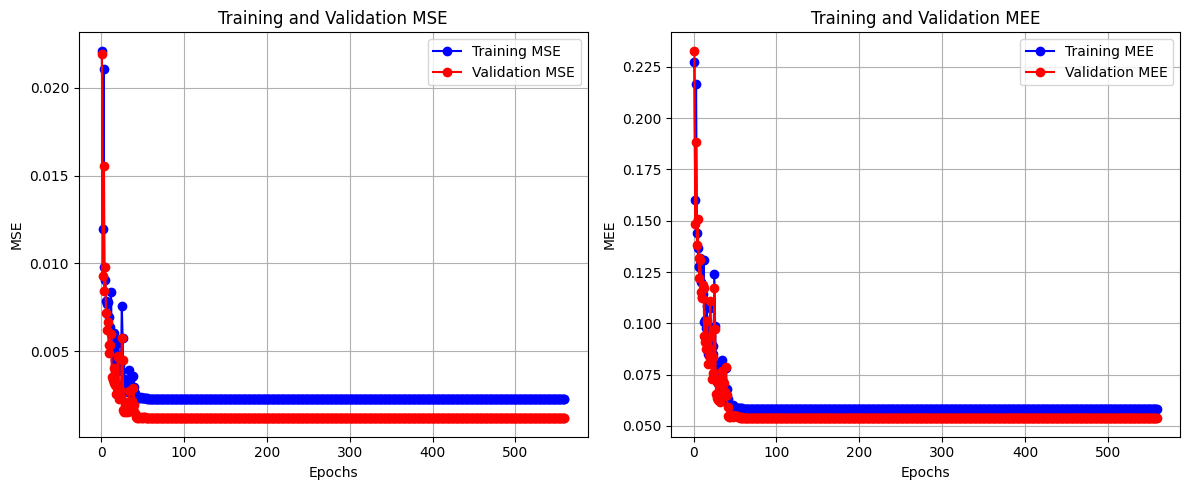

{'learning_rate': 0.05, 'epochs': 800, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.06789262403152707


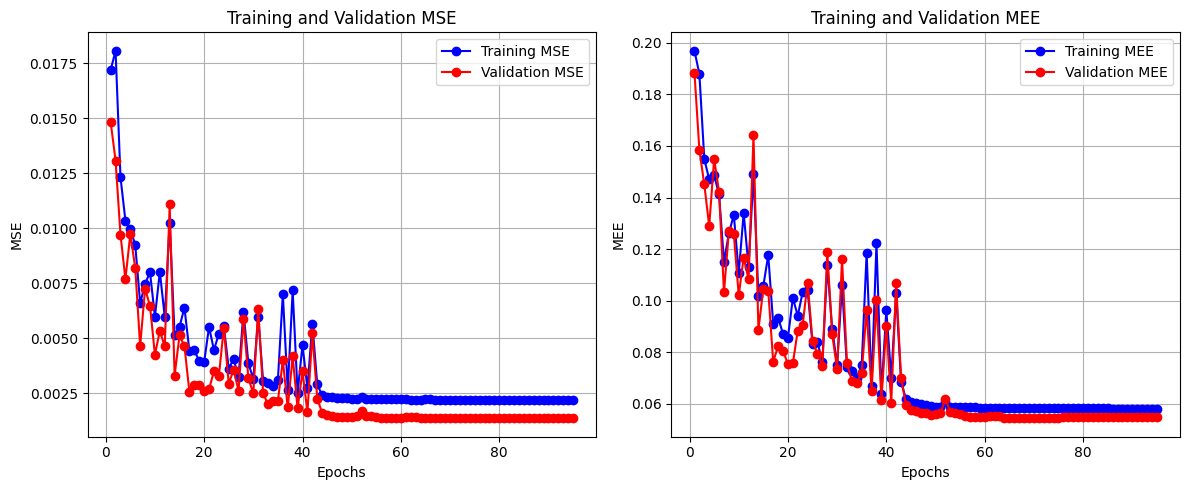

{'learning_rate': 0.060000000000000005, 'epochs': 800, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 2, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.07072042851695598


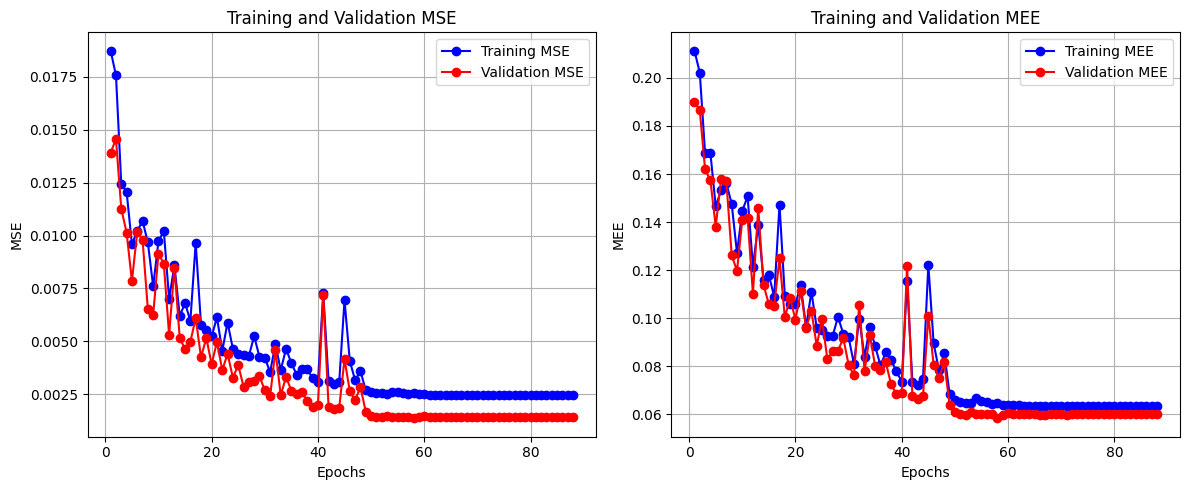

{'learning_rate': 0.05, 'epochs': 800, 'batch_size': 32, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score: 0.07082254948197408


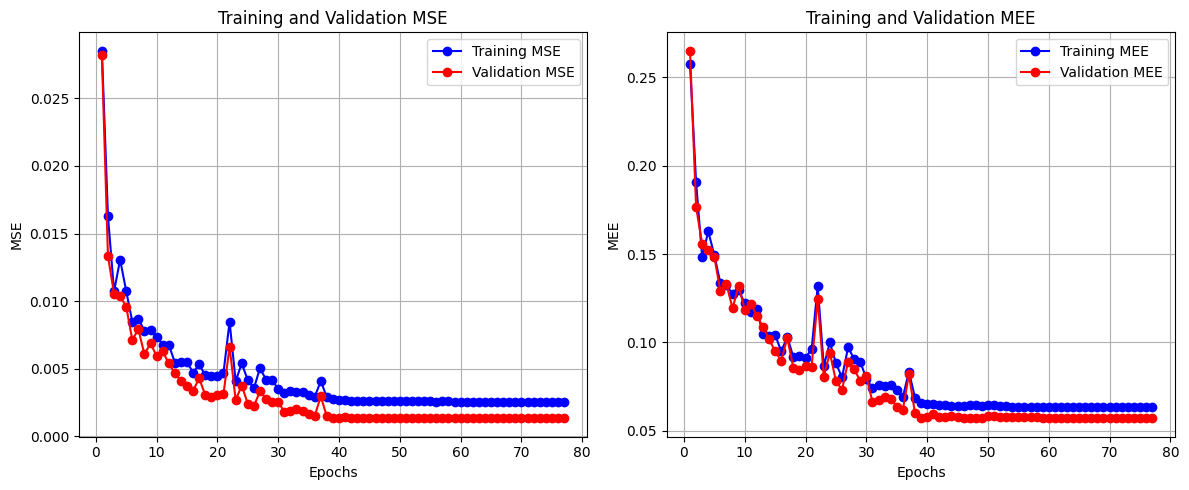

{'learning_rate': 0.060000000000000005, 'epochs': 800, 'batch_size': 64, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.071612565999666


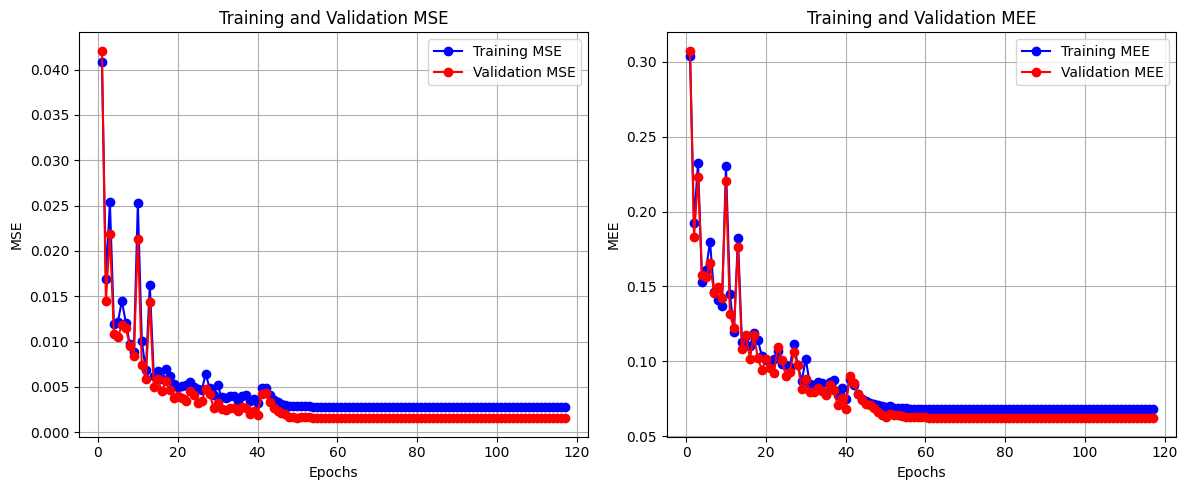

{'learning_rate': 0.04, 'epochs': 800, 'batch_size': 32, 'hidden_size': 70, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.0740808585288524


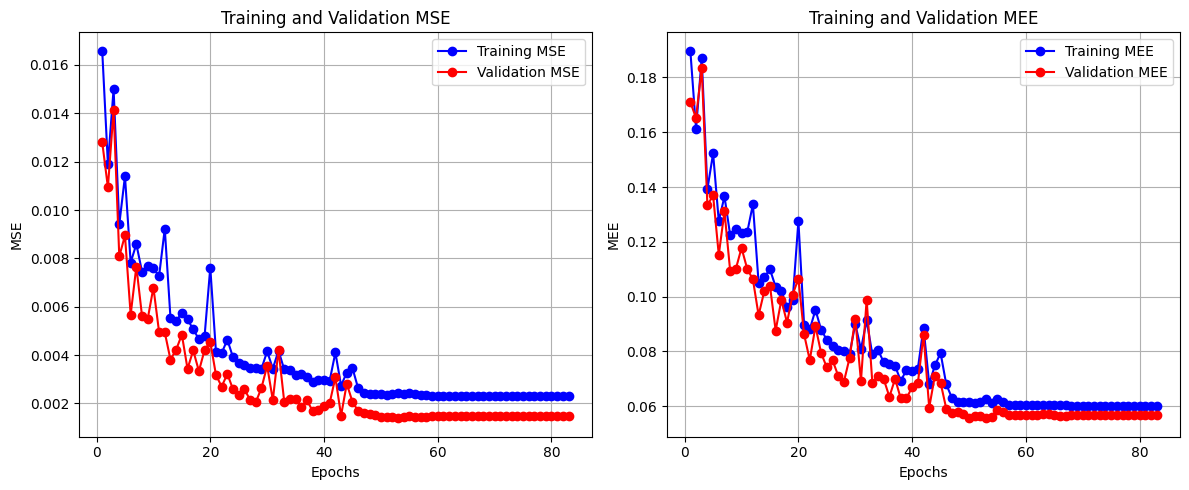

{'learning_rate': 0.04, 'epochs': 800, 'batch_size': 32, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score: 0.07460553600229256


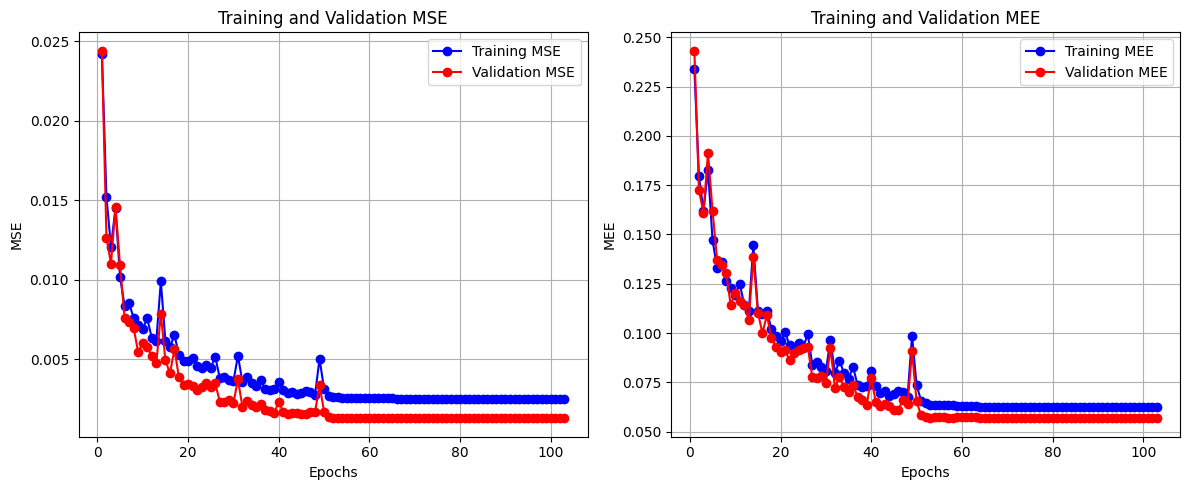

{'learning_rate': 0.05, 'epochs': 800, 'batch_size': 64, 'hidden_size': 60, 'hidden_layers': 3, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.07537658271727148


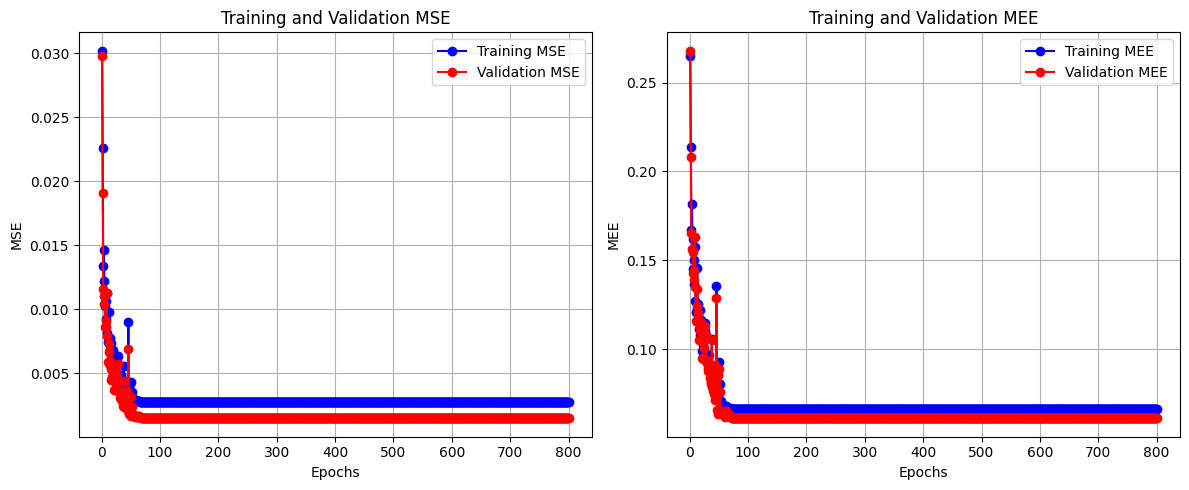

{'learning_rate': 0.060000000000000005, 'epochs': 800, 'batch_size': 64, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.4, 'regularization': 0.001, 'patience': 30}
Score: 0.0773378098570967


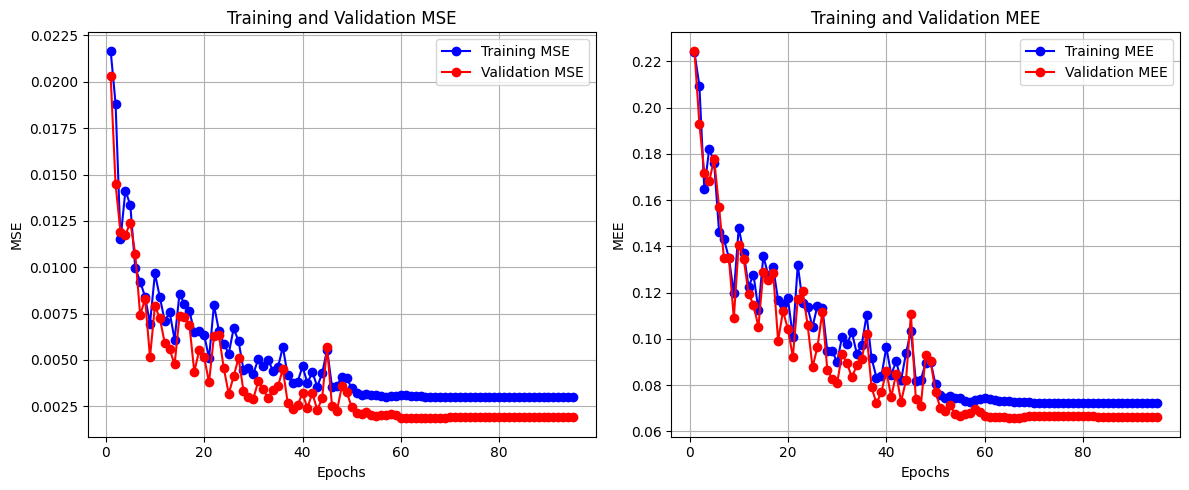

{'learning_rate': 0.060000000000000005, 'epochs': 800, 'batch_size': 32, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.5, 'regularization': 0.001, 'patience': 30}
Score: 0.0773853008337025


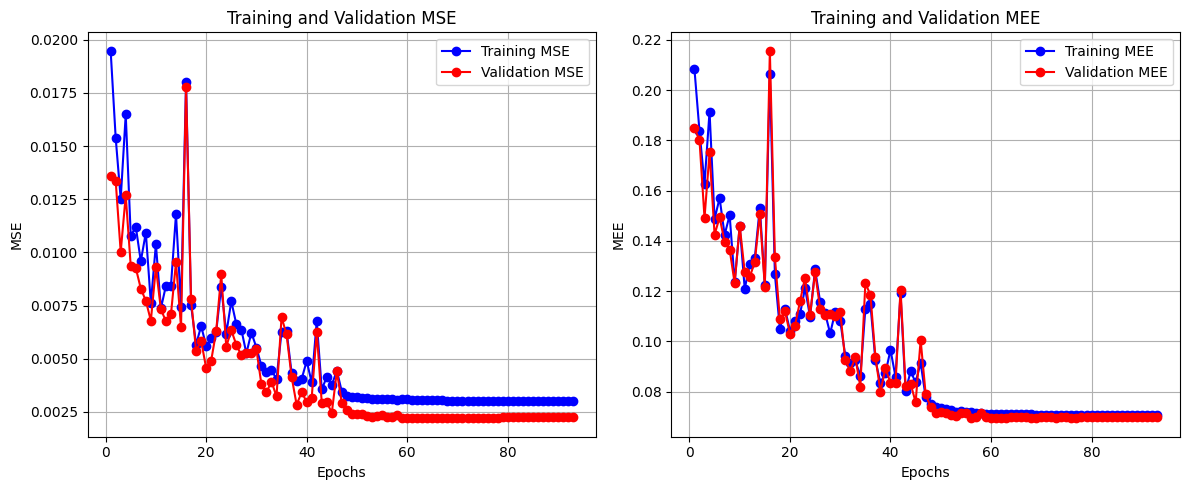

In [239]:
# Plot the training history for each of the best models found
print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories, best_params_list, best_scores)):
    print(f"{params}") # Print the hyperparameters
    print(f"Score: {score}") # Print the validation score
    plot_training_history(history) # Plot the training and validation loss and accuracy